### Imports

In [2]:
# Standard libraries
import math
import re

# Other libraries
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import fasttext
from nltk import corpus, stem
from collections import Counter
from wordcloud import WordCloud

### Load dataset

In [2]:
df = pd.read_json(
    "./data/data.zip",
    orient="records"
)

In [3]:
df["year"] = df["created.date-parts"].apply(lambda x: x[0][0] if isinstance(x, list) else None)

### Exploratory Data Analysis

#### 1) Number of publications

In [35]:
df.shape[0]

70740

#### 2) Titles

In [4]:
print(f"There are {df['title'].dropna().shape[0]} ({df['title'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null titles.")

There are 68211 (96.42%) non-null titles.


#### 3) Abstract

In [6]:
print(f"There are {df['abstract'].dropna().shape[0]} ({df['abstract'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null abstracts.")

There are 17290 (24.44%) non-null abstracts.


#### 4) Subject

In [7]:
print(f"There are {df['subject'].dropna().shape[0]} ({df['subject'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null subjects.")

There are 57948 (81.92%) non-null subjects.


#### 5) Year

In [8]:
print(f"There are {df['year'].dropna().shape[0]} ({df['year'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null years.")

There are 68207 (96.42%) non-null years.


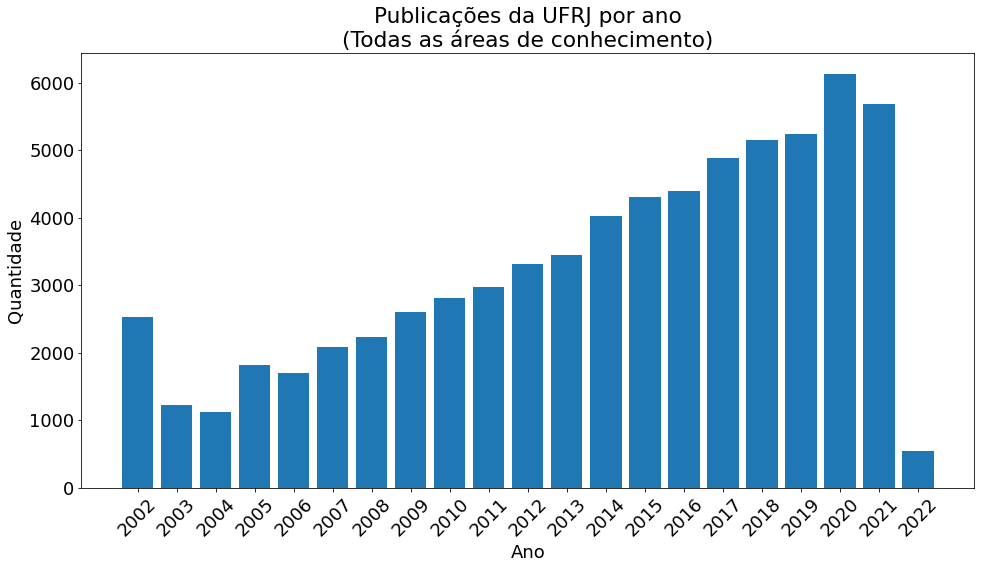

In [159]:
_ = df['year'].value_counts().to_dict()
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(_.keys(), _.values())
ax.set_xticks(list(_.keys()))
ax.set_title("Publicações da UFRJ por ano\n(Todas as áreas de conhecimento)")
ax.set_xlabel("Ano")
ax.set_ylabel("Quantidade");
plt.tick_params(axis="x", rotation=45)
plt.rcParams.update({'font.size': 18})
fig.savefig("./data/pub_per_year.pdf")

#### 6) Language

In [11]:
df["language"].value_counts(dropna=False)

en      44193
None    26226
pt        205
fr         57
es         37
de         21
ja          1
Name: language, dtype: int64

#### 7) Subjects

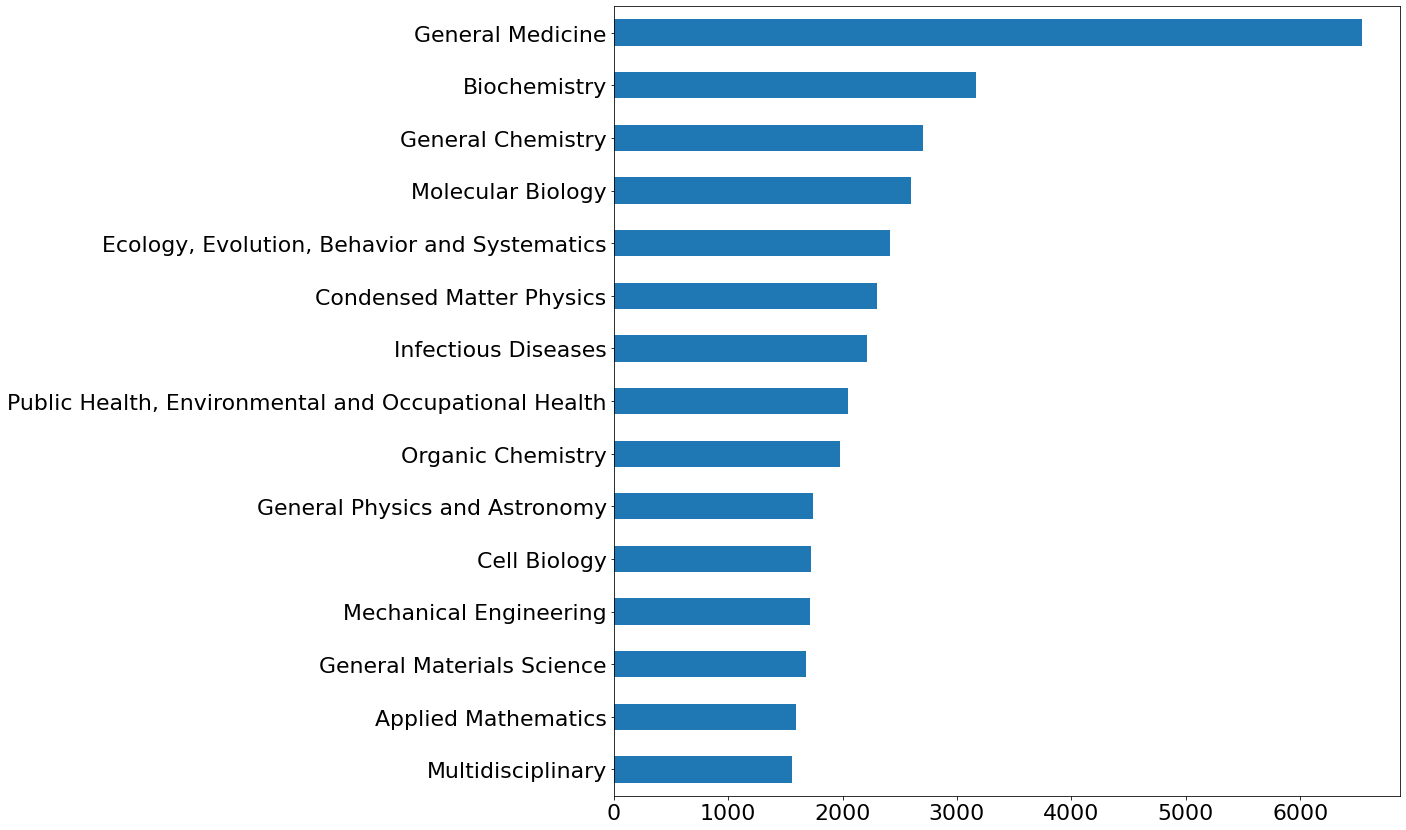

In [168]:
df.explode("subject")["subject"].value_counts().head(15).iloc[::-1].plot(kind="barh", figsize=(20,12));
plt.tight_layout()
plt.rcParams.update({'font.size': 22})
plt.savefig("./data/subjects.pdf")

### Data treatment

#### 1) Remove new lines

In [15]:
df_treated = df.replace(r'\n',' ', regex=True) 

#### 2) Remove HTML markup tags

In [16]:
df_treated['title'] = df_treated['title'].str.replace(r'<[^<>]*>', '', regex=True)

### 3) Remove null titles

In [17]:
df_treated = df_treated[df_treated['title'].notna()]

#### 4) Use `fasttext` to identify language of records

In [3]:
path_to_pretrained_model = './data/model.bin'
fmodel = fasttext.load_model(path_to_pretrained_model)

In [19]:
for index, row in df_treated.iterrows():
    row = row.copy()
    if (row['abstract'] != None):
        label, n = fmodel.predict(row['abstract'])
        if label != [] and n[0] > 0.9:
            df_treated.loc[index, 'language'] = label[0][9:11] # Language labels: 'en', 'pt', etc

#### 5) Remove stopwords

In [20]:
stopwords = corpus.stopwords.words('english') + corpus.stopwords.words('portuguese')

df_treated['title'] = df_treated.title.str.replace("[^\w\s]", "", regex=True).str.lower()
df_treated['title'] = df_treated['title'].apply(lambda x: [item for item in x.split() if item not in stopwords])

#### 6) Apply Porter Stemmer to titles

In [21]:
stemmer = stem.PorterStemmer()
stemmer_dict = dict()

def stem_sentences(sentence):
    stemmed_tokens = list()
    for token in sentence:
        stemmed_token = stemmer.stem(token)
        stemmed_tokens.append(stemmed_token)
        stemmer_dict[stemmed_token] = token
    stemmerized_word = ' '.join(stemmed_tokens)
    return stemmerized_word

df_treated['title'] = df_treated['title'].apply(stem_sentences)

#### 7) Filter for only English language titles

In [23]:
df_english = df_treated.loc[df['language'] == 'en']

#### 8) Filter only for papers with computation related subjects

In [58]:
comp_subjects = [
    'Computational Mathematics',
    'Computational Theory and Mathematics',
    'Computer Science Applications',
    'Information Systems',
    'Software',
    'Theoretical Computer Science',
    'Computer Networks and Communications',
    'Hardware and Architecture',
    'Information Systems and Management',
    'Management Information Systems',
    'Artificial Intelligence',
    'Computer Graphics and Computer-Aided Design',
    'Computer Vision and Pattern Recognition',
    'Computer Science (miscellaneous)',
    'Human-Computer Interaction'
]

df_comp = df_english.explode("subject")
df_comp["subject"] = df_comp["subject"].apply(lambda x: x if x in comp_subjects else float("NaN"))
df_comp = df_comp.loc[~pd.isna(df_comp["subject"])].drop_duplicates("title")

### Computation areas analysis

#### 1) Number of publications of computation subjects

In [173]:
df_comp.shape[0]

2131

#### 2) Publications of computation subjects per year

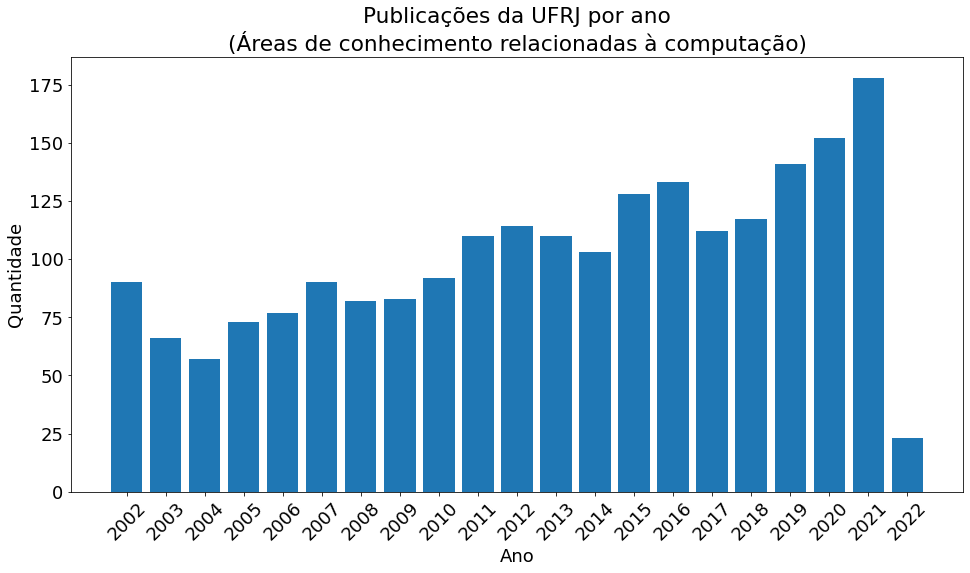

In [158]:
_ = df_comp['year'].value_counts().to_dict()
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(_.keys(), _.values())
ax.set_xticks(list(_.keys()))
ax.set_title("Publicações da UFRJ por ano\n(Áreas de conhecimento relacionadas à computação)")
ax.set_xlabel("Ano")
ax.set_ylabel("Quantidade");
plt.tick_params(axis="x", rotation=45)
plt.rcParams.update({'font.size': 18})
fig.savefig("./data/comp_pub_per_year.pdf")

#### 3) Number of publications per subject for computation subjects

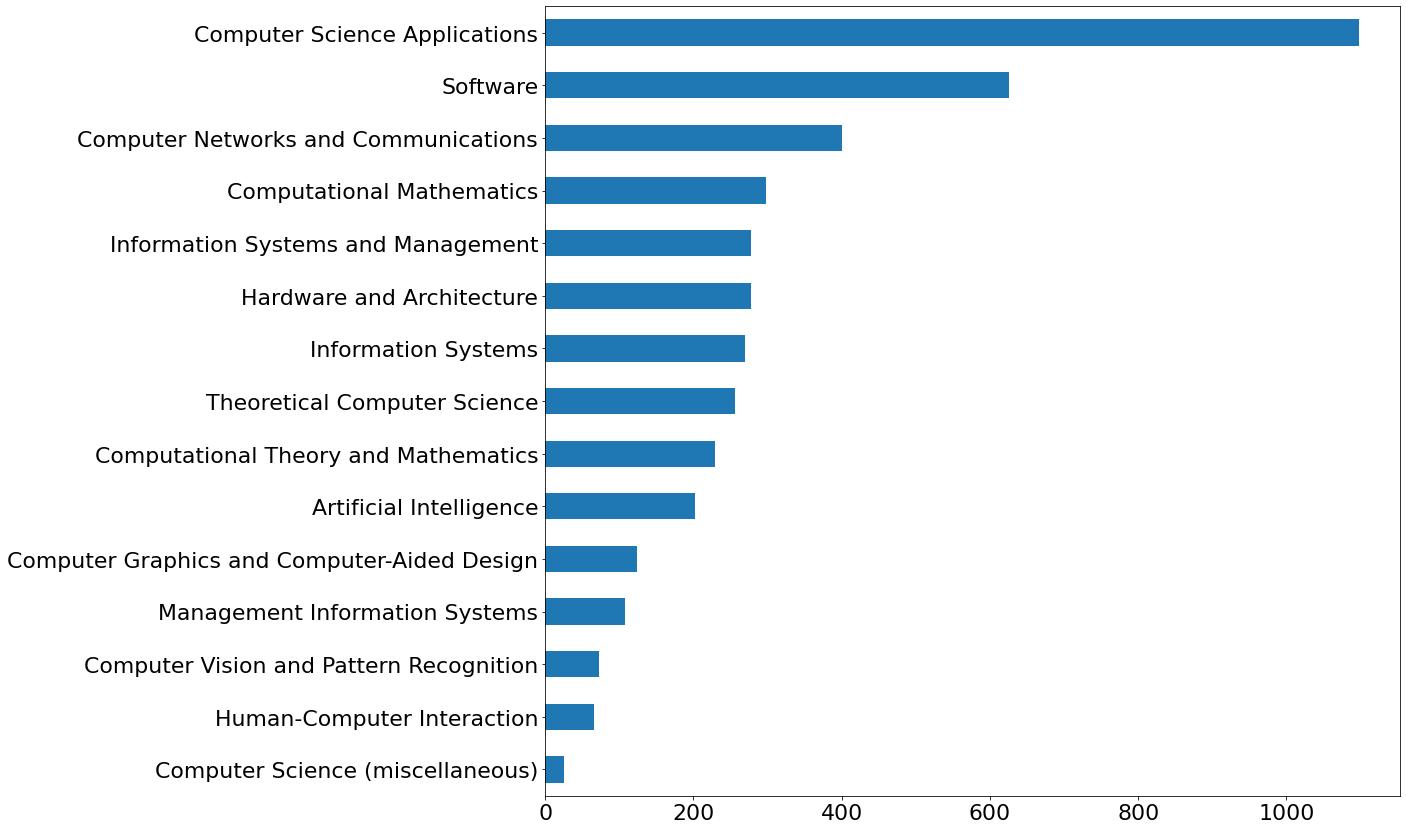

In [172]:
df.explode("subject")["subject"].apply(lambda x: x if x in comp_subjects else float("NaN")).value_counts().iloc[::-1].plot(kind="barh", figsize=(20,12));
plt.tight_layout()
plt.rcParams.update({'font.size': 22})
plt.savefig("./data/comp_subjects.pdf")

### Calculate TF-IDF for title words

#### 1) Define TF-IDF functions

In [60]:
def generate_dict(df):
    dict = {}
    for index, row in df.iterrows():
        try:
            dict[int(row['year'])] += row['title']
        except:
            dict[int(row['year'])] = row['title']
    return dict

def invert_tf(tf):
    itf = {}
    for doc, words in tf.items():
        for word in words:
            if word not in itf:
                itf[word] = {}
            try:
                itf[word][doc] = tf[doc][word]
            except:
                itf[word][doc] = {}
    return itf

def create_tf_idf(df):
        dict = generate_dict(df)
        inverted_list = {}

        for num, text in dict.items():
            word_tokens = text.split(' ')

            for word in word_tokens:
                if (word not in inverted_list):
                    inverted_list[word] = []
                inverted_list[word] = inverted_list[word] + [num]

        tf = {}
        for word, documents in inverted_list.items():
            for doc in documents:
                if (doc not in tf):
                    tf[doc] = {}
                try:
                    tf[doc][word] += 1
                except:
                    tf[doc][word] = 1
        
        idf = {}
        itf = invert_tf(tf)
        for word in itf:
            idf[word] = math.log(len(tf)/len(itf[word]))
        
        tf_idf = {}
        for doc, words in tf.items():
            for word in words:
                if doc not in tf_idf:
                    tf_idf[doc] = {}
                try:
                    tf_idf[doc][word] = tf[doc][word] * idf[word]
                except:
                    tf_idf[doc][word] = 0
        return tf_idf

#### 2) Calculate TF-IDF

In [63]:
tf_idf = create_tf_idf(df_comp)
general_tf_idf = dict()
common_list = list()

for k in tf_idf.keys():
    for key, value in tf_idf[k].items():
        if key not in general_tf_idf.keys():
            general_tf_idf[key] = value
            
c = Counter(general_tf_idf)
for i in range(1,41):
    common_list += [c.most_common()[-i][0]] * int(1000-(c.most_common()[-i][1]*1000))
    common_list.append(c.most_common()[-i][0])

### Wordclouds

#### 1) Wordcloud generation function

In [142]:
def generate_wordcloud(l, label):
    words = " ".join(s for s in l)

    wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(words)
    wordcloud.to_file("./data/wc_{}.pdf".format(label))
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()
    plt.imshow(wordcloud)

#### 2) General wordcloud

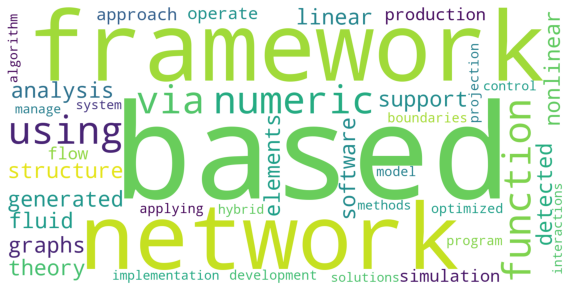

In [144]:
generate_wordcloud([stemmer_dict[i] for i in set(common_list)], "general")

#### 3) Year-range wordcloud

2002
2005
2008
2011
2014
2017
2020


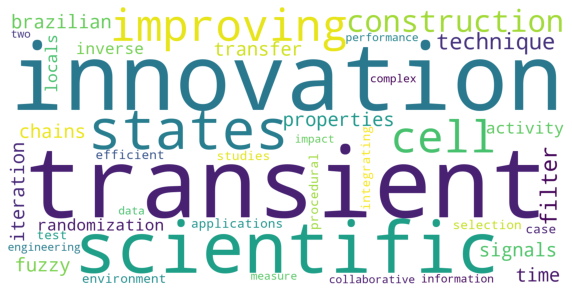

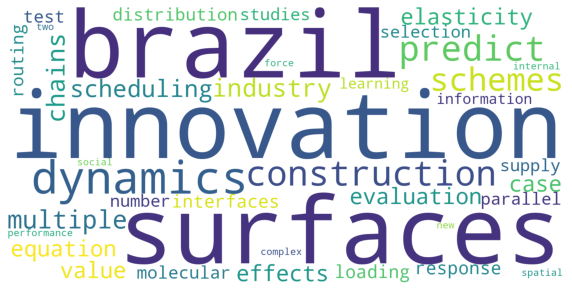

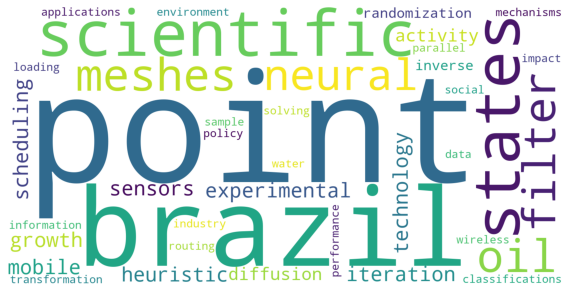

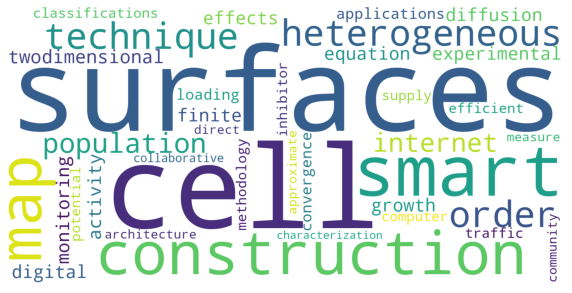

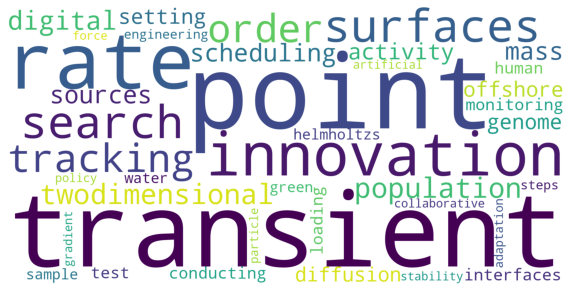

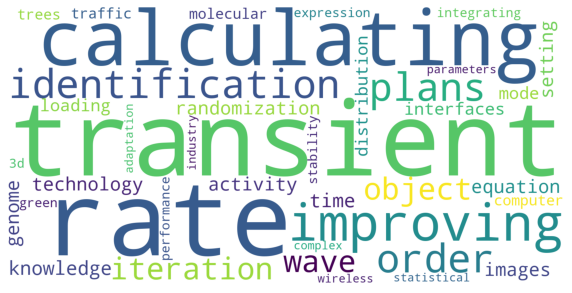

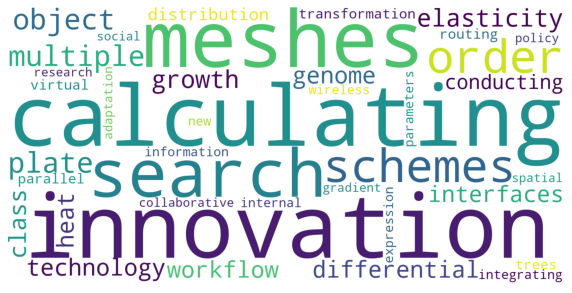

In [145]:
cloud_dict = dict()

for year in range(2002,2022,3):
    c = Counter(
        {k: tf_idf[year].get(k, 0) + tf_idf[year+1].get(k, 0) + tf_idf[year+2].get(k, 0) for k in set(tf_idf[year]) | set(tf_idf[year+1]) | set(tf_idf[year+2])}
    )
    l = []
    count = 0
    i = 0
    while count < 40:
        if c.most_common()[-i][0] not in common_list:
            l += [c.most_common()[-i][0]] * int(1000-(c.most_common()[-i][1]*1000))
            count += 1
        i += 1
    print(year)
    stemmer_l = [stemmer_dict[i] for i in set(l)]
    cloud_dict[year] = set(stemmer_l)
    generate_wordcloud(stemmer_l, year)

#### 4) Changes in subsequent year-ranges

In [138]:
# [2002, 2005, 2008, 2011, 2014, 2017, 2020]
for i in [2002, 2005, 2008, 2011, 2014, 2017]:
    print(i)
    print(cloud_dict[i + 3] - cloud_dict[i])
    print()

2002
{'routing', 'brazil', 'supply', 'industry', 'predict', 'equation', 'interfaces', 'elasticity', 'force', 'schemes', 'surfaces', 'evaluation', 'molecular', 'value', 'learning', 'response', 'parallel', 'multiple', 'dynamics', 'number', 'distribution', 'scheduling', 'loading', 'effects', 'new', 'social', 'spatial', 'internal'}

2005
{'point', 'scientific', 'oil', 'classifications', 'filter', 'diffusion', 'iteration', 'neural', 'sample', 'growth', 'meshes', 'technology', 'states', 'applications', 'transformation', 'solving', 'heuristic', 'experimental', 'policy', 'sensors', 'water', 'mechanisms', 'inverse', 'activity', 'data', 'environment', 'wireless', 'randomization', 'mobile', 'impact'}

2008
{'supply', 'heterogeneous', 'cell', 'smart', 'map', 'order', 'methodology', 'internet', 'equation', 'characterization', 'collaborative', 'digital', 'twodimensional', 'population', 'architecture', 'surfaces', 'monitoring', 'finite', 'traffic', 'potential', 'measure', 'inhibitor', 'approximate', 